# E&M Final Project Report
### Ian Eykamp

I wound and tested three over-wire transformers for non-invasive current sensing. They are placed over a current-carrying wire connected to a waveform generator at 400kHz with a 0.2175V amplitude, in series with a 100Ω resistor to transform the voltage waveform into a current. The theoretical output voltages are calculated and compared with the measured data below.

![Experimental setup](experimental_setup.jpg)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"
print(f"Testing units: mu_0 = {(1 * units.mu_0).to_compact(units.tesla * units.meter / units.amp) / 4 / np.pi}")

Using matplotlib backend: TkAgg
Testing units: mu_0 = 0.10 m·µT/A


## Calculations

I tested three transformers: a small diameter core with 30 turns, a small diameter core with 60 turns, and a large diameter core with 60 turns. I expected the small diameter core with 60 turns to generate the greatest voltage difference, because the core is closer to the wire where the H field is stronger. Next is the large diameter core with 60 turns, then the small diameter core with 30 turns. My experimental data match my predictions quite well.

I wound the current-sensing transformers using ferrite beads which I purchased [online](https://www.amazon.com/dp/B07ZQZQ5BQ). The ferrite cores have two semicircular halves. They have a plastic casing which snaps shut around a wire, pressing the cores together to form a continuous loop. Even when the casing is snapped shut, it is possible there is still a air gap between the cores due to manufacturing defects in the casing. Because $\mu \gg \mu_0$, the reluctance $\mathcal{R}$, and thus the flux, is strongly dependent on the size of the air gap. I assumed a value for $\mu$ and adjusted the air gap length for each calculation until I achieved the same inductance as I measured for each core on the LCR meter. I found that a gap of around ten thousandths of an inch is enough to explain my measurements using a [typical](https://product.tdk.com/en/system/files?file=dam/doc/product/ferrite/ferrite/ferrite-core/catalog/ferrite_mn-zn_material_characteristics_en.pdf) value for the permeability of a ferrite core $\mu \approx 3000 \mu_0$. Because there are two gaps in the ferrite core, this means each side would have a gap of about 5 thou, which can reasonably be imagined.

From Ampere's law, we have that $\mathcal{F} = 1 \cdot I_{through} = \oint H ds = \Phi \cdot \mathcal{R}$, where $\mathcal{R} = \mathcal{R_{core}} + \mathcal{R_{gap}} = \frac{2 \pi r}{\mu A} + \frac{l_{gap}}{\mu_0 A}$, so $\Phi = \frac{I_{through}}{\mathcal{R}} = \frac{I_{through}}{(\frac{2 \pi r}{\mu A} + \frac{l_{gap}}{\mu_0 A})}$.

From Faraday's law, we have that $\Delta V = \frac{d}{dt} \bigl[\Phi\bigr]$. Thus, $\Delta V = \frac{d}{dt} \Bigl[ \frac{I_{through}}{\mathcal{R}} \Bigr] = \frac{1}{\mathcal{R}} \cdot \frac{d}{dt}\bigl[I_{through}\bigr]$.

Assuming $I_{through}$ takes the form $I_{through}(t) = I_{DC} + I_0 sin(\omega t)$, then $\Delta V = \frac{1}{\mathcal{R}} \cdot \frac{dI_{through}(t)}{dt} = \frac{1}{\mathcal{R}} \cdot \omega I_0 cos(\omega t)$. This is shifted from the current function by 90 degrees and scales proportionally to the frequency of the measured current.

In [50]:
def parallel(x, y):
    return 1 / (1 / x + 1 / y)

class FerriteCore():
    def __init__(self, inner_diameter, outer_diameter, length, turns, gap_length = 1 * units.thou, mu_r = 3000, I0 = 0.1 * units.amp, freq = 1 * units.megahertz * units.revolution) -> None:
        # all quantities passed in should have pint units attached
        self.inner_diameter = inner_diameter
        self.outer_diameter = outer_diameter
        self.length = length
        self.turns = turns
        self.gap_length = gap_length
        self.I0 = I0
        self.freq = freq

        self.r = (self.inner_diameter + self.outer_diameter) / 2
        self.A = (self.outer_diameter - self.inner_diameter) * self.length

        self.mu = units.mu_0 * mu_r

        self.core_length = 2 * np.pi * self.r
        self.core_reluctance = (self.core_length - self.gap_length) / (self.mu * self.A)
        self.gap_reluctance = self.gap_length / (units.mu_0 * self.A)
        self.reluctance = self.core_reluctance + self.gap_reluctance
        self.gap_reluctance_factor = self.gap_reluctance / self.reluctance

        self.permeance = 1 / self.reluctance
        self.inductance = self.turns ** 2 * self.permeance

        print(f"Using a radius of {self.r} and an air gap length of {self.gap_length}")
        print(f"The air gap contributes to {np.round(self.gap_reluctance_factor.to_base_units() * 100, 1)}% of the total reluctance.")
        print(f"Inductance: {(self.inductance).to_compact(units.henry)}")

        self.dIdt = self.I0 * self.freq
        self.flux = self.I0 / self.reluctance
        self.flux_linkage = self.flux * self.turns
        self.dV = self.flux_linkage * self.freq
        self.H = self.flux / (2 * np.pi * self.r) * self.reluctance
        self.B_core = self.H * self.mu
        self.B_air = self.H * units.mu_0
        # print(f"Your B value is {self.B_core.to_compact(units.tesla)}. The maximum is on the order of 530mT.")
        # print(f"Your air gap B value is {self.B_air.to_compact(units.tesla)}. The maximum is on the order of 530mT.")
        print(f"Expected voltage difference across the transformer terminals: {self.dV.to_compact(units.volt)}")
        print()

V0 = 0.2175 * units.volt
Rshunt = 100 * units.ohm
I0 = V0 / Rshunt
freq = 400e3 * units.hertz * units.cycle

darkblue_ferrite = FerriteCore(inner_diameter = 0.35 * units.inch, outer_diameter = 0.625 * units.inch, length = 1.102 * units.inch, turns = 60, gap_length = 6.8 * units.thou, I0 = I0, freq = freq, mu_r = 3000)
pink_ferrite = FerriteCore(inner_diameter = 0.5 * units.inch, outer_diameter = 0.8 * units.inch, length = 1.156 * units.inch, turns = 60, gap_length = 11.2 * units.thou, I0 = I0, freq = freq, mu_r = 3000)
lightblue_ferrite = FerriteCore(inner_diameter = 0.35 * units.inch, outer_diameter = 0.625 * units.inch, length = 1.102 * units.inch, turns = 30, gap_length = 8.5 * units.thou, I0 = I0, freq = freq, mu_r = 3000)


Using a radius of 0.49 in and an air gap length of 6.80 th
The air gap contributes to 87.00% of the total reluctance.
Inductance: 4.45 mH
Expected voltage difference across the transformer terminals: 405.76 mV

Using a radius of 0.65 in and an air gap length of 11.20 th
The air gap contributes to 89.20% of the total reluctance.
Inductance: 3.17 mH
Expected voltage difference across the transformer terminals: 289.11 mV

Using a radius of 0.49 in and an air gap length of 8.50 th
The air gap contributes to 89.30% of the total reluctance.
Inductance: 914.63 µH
Expected voltage difference across the transformer terminals: 166.66 mV



## Oscilloscope Data

I ran the tests at 400kHz, 0.2175V input current sine wave. The amplitudes of the measured signals match extremely well with the theoretical calculations. See the printout just above the graph for a comparison.

I_sense_amplitude:  217.50 mV, corresponding simulated amplitude: 217.50 mV
small_30_amplitude: 140.00 mV, corresponding predicted amplitude: 166.66 mV
large_60_amplitude: 300.00 mV, corresponding predicted amplitude: 289.11 mV
small_60_amplitude: 532.00 mV, corresponding predicted amplitude: 405.76 mV


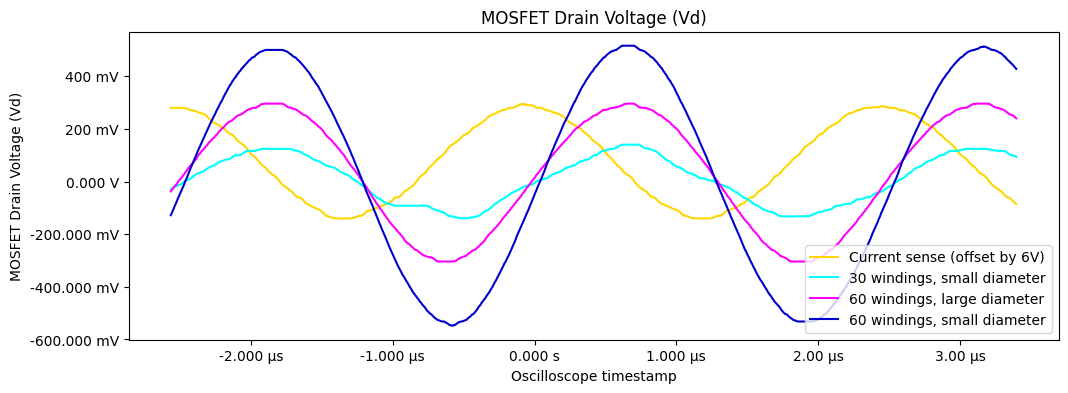

In [51]:
(df_amplitude, tspan, tstep) = helper.read_rigol_csv("transformer_amplitudes.csv", ch1 = "I_sense", ch2 = "small_30", ch3 = "large_60", ch4 = "small_60", shift = 0)
df_amplitude["I_sense_corrected"] = -(df_amplitude["I_sense"] + 6)

I_sense_range = (np.nanmax(df_amplitude["I_sense_corrected"]), np.nanmin(df_amplitude["I_sense_corrected"]))
small_30_range = (np.nanmax(df_amplitude["small_30"]), np.nanmin(df_amplitude["small_30"]))
large_60_range = (np.nanmax(df_amplitude["large_60"]), np.nanmin(df_amplitude["large_60"]))
small_60_range = (np.nanmax(df_amplitude["small_60"]), np.nanmin(df_amplitude["small_60"]))

I_sense_amplitude = (I_sense_range[0] - I_sense_range[1]) / 2
small_30_amplitude = (small_30_range[0] - small_30_range[1]) / 2
large_60_amplitude = (large_60_range[0] - large_60_range[1]) / 2
small_60_amplitude = (small_60_range[0] - small_60_range[1]) / 2

print(f"I_sense_amplitude:  {si_format(I_sense_amplitude, precision = 2)}V, corresponding simulated amplitude: {si_format(I_sense_amplitude, precision = 2)}V")
print(f"small_30_amplitude: {si_format(small_30_amplitude, precision = 2)}V, corresponding predicted amplitude: {lightblue_ferrite.dV.to_compact(units.volt)}")
print(f"large_60_amplitude: {si_format(large_60_amplitude, precision = 2)}V, corresponding predicted amplitude: {pink_ferrite.dV.to_compact(units.volt)}")
print(f"small_60_amplitude: {si_format(small_60_amplitude, precision = 2)}V, corresponding predicted amplitude: {darkblue_ferrite.dV.to_compact(units.volt)}")

plt.figure(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)")
plt.plot(df_amplitude["t"], df_amplitude["I_sense_corrected"], color = "gold", label = "Current sense (offset by 6V)")
plt.plot(df_amplitude["t"], df_amplitude["small_30"], color = "cyan", label = "30 windings, small diameter")
plt.plot(df_amplitude["t"], df_amplitude["large_60"], color = "magenta", label = "60 windings, large diameter")
plt.plot(df_amplitude["t"], df_amplitude["small_60"], color = "mediumblue", label = "60 windings, small diameter")
plt.legend(loc = "lower right")